In [1]:
from load_dataset import load_german_credit_dataset, load_simplified_german_credit_dataset
from model_manager import PytorchModelManager
from cf_engine.engine import CFEnginePytorch
from cf_engine.counterfactual import CounterfactualExampleBySubset

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [3]:
dataset = load_simplified_german_credit_dataset()
mm = PytorchModelManager(dataset)
dm = mm.get_dir_manager()
# try:
#     mm.load_model()
# except FileNotFoundError:
#     mm.train()
#     mm.save_model()
mm.train()
mm.save_model()
engine = CFEnginePytorch(mm, dataset)

/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, loss=0.722, train_accuracy=0.698, test_accuracy=0.710
Epoch: 1, loss=0.634, train_accuracy=0.698, test_accuracy=0.710
Epoch: 2, loss=0.516, train_accuracy=0.739, test_accuracy=0.715
Epoch: 3, loss=0.526, train_accuracy=0.735, test_accuracy=0.720
Epoch: 4, loss=0.606, train_accuracy=0.754, test_accuracy=0.730
Epoch: 5, loss=0.634, train_accuracy=0.752, test_accuracy=0.740
Epoch: 6, loss=0.753, train_accuracy=0.760, test_accuracy=0.730
Epoch: 7, loss=0.491, train_accuracy=0.755, test_accuracy=0.720
Epoch: 8, loss=0.558, train_accuracy=0.761, test_accuracy=0.715
Epoch: 9, loss=0.658, train_accuracy=0.759, test_accuracy=0.735
Epoch: 10, loss=0.520, train_accuracy=0.756, test_accuracy=0.735
Epoch: 11, loss=0.482, train_accuracy=0.766, test_accuracy=0.725
Epoch: 12, loss=0.668, train_accuracy=0.767, test_accuracy=0.725
Epoch: 13, loss=0.430, train_accuracy=0.775, test_accuracy=0.730
Epoch: 14, loss=0.405, train_accuracy=0.774, test_accuracy=0.735
Epoch: 15, loss=0.485, train_accura

In [4]:
dataset.get_columns()

['Age',
 'Sex_male',
 'Sex_female',
 'Job_2',
 'Job_1',
 'Job_3',
 'Job_0',
 'Housing_own',
 'Housing_free',
 'Housing_rent',
 'Saving accounts_unknown',
 'Saving accounts_little',
 'Saving accounts_quite rich',
 'Saving accounts_rich',
 'Saving accounts_moderate',
 'Checking account_little',
 'Checking account_moderate',
 'Checking account_unknown',
 'Checking account_rich',
 'Credit amount',
 'Duration',
 'Purpose_radio/TV',
 'Purpose_education',
 'Purpose_furniture/equipment',
 'Purpose_car',
 'Purpose_business',
 'Purpose_domestic appliances',
 'Purpose_repairs',
 'Purpose_vacation/others',
 'Risk_good',
 'Risk_bad']

In [5]:
target_name = dataset.get_target_names(False)
pre_target_name = '{}_pred'.format(target_name)
desc = dataset.get_description()
neg = desc[target_name]['category'][0]
pos = desc[target_name]['category'][1]
def plot_subset_cf(subset_attr_cf):
    for i, (feature, subset_cf) in enumerate(subset_attr_cf.items()):
        cf_df = subset_cf.get_cf().reset_index(drop=True)
        original_df = subset_cf.get_instance().reset_index(drop=True)
#         valid_index = cf_df[pre_target_name] != \
#             original_df.loc[cf_df['OriginIndex'], pre_target_name]
#         valid_cf = cf_df.loc[valid_index, :]
#         valid_instance = original_df.loc[valid_cf['OriginIndex'], :]
        valid_index = cf_df[pre_target_name] != original_df[pre_target_name]
        valid_cf = cf_df[valid_index]
        valid_instance = original_df[valid_index]
        pos_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == pos][feature]
        neg_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == neg][feature]
        pos_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == pos][feature]
        neg_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == neg][feature]
        # add subplots
        bins = 25
        plt.subplot(len(subset_attr_cf), 2, i*2+1)
        if desc[feature]['type'] == 'numerical':
            plt.hist(neg_valid_instance_attr_value, bins=bins, alpha=0.5, label='neg', color='b')
            plt.hist(pos_valid_cf_attr_value, bins=bins, alpha=0.5, label='pos', color='r')
        else:
            names = desc[feature]['category']
            neg_value = [(neg_valid_instance_attr_value == cat).sum() for cat in names]
            pos_value = [(pos_valid_cf_attr_value == cat).sum() for cat in names]
            names = [str(cat) for cat in names]
            plt.bar(names, neg_value, alpha=0.5, label='neg', color='b')
            plt.bar(names, pos_value, alpha=0.5, label='pos', color='r')
        
        plt.legend(loc='upper right')
        plt.title('{}: neg->pos'.format(feature))
        plt.subplot(len(subset_attr_cf), 2, i*2+2)
        if desc[feature]['type'] == 'numerical':
            plt.hist(pos_valid_instance_attr_value, bins=bins, alpha=0.5, label='pos', color='r')
            plt.hist(neg_valid_cf_attr_value, bins=bins, alpha=0.5, label='neg', color='b')
        else:
            names = desc[feature]['category']
            neg_value = [(neg_valid_cf_attr_value == cat).sum() for cat in names]
            pos_value = [(pos_valid_instance_attr_value == cat).sum() for cat in names]
            names = [str(cat) for cat in names]
            plt.bar(names, pos_value, alpha=0.5, label='pos', color='r')
            plt.bar(names, neg_value, alpha=0.5, label='neg', color='b')
        plt.legend(loc='upper right')
        plt.title('{}: pos->neg'.format(feature))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

[1000/1000]  Epoch-0, time cost: 20.650s, loss: 9.720, iteration: 2000, validation rate: 0.986
Total time cost: 20.825, validation rate: 0.986, average distance: 1.227, average loss: 9.720


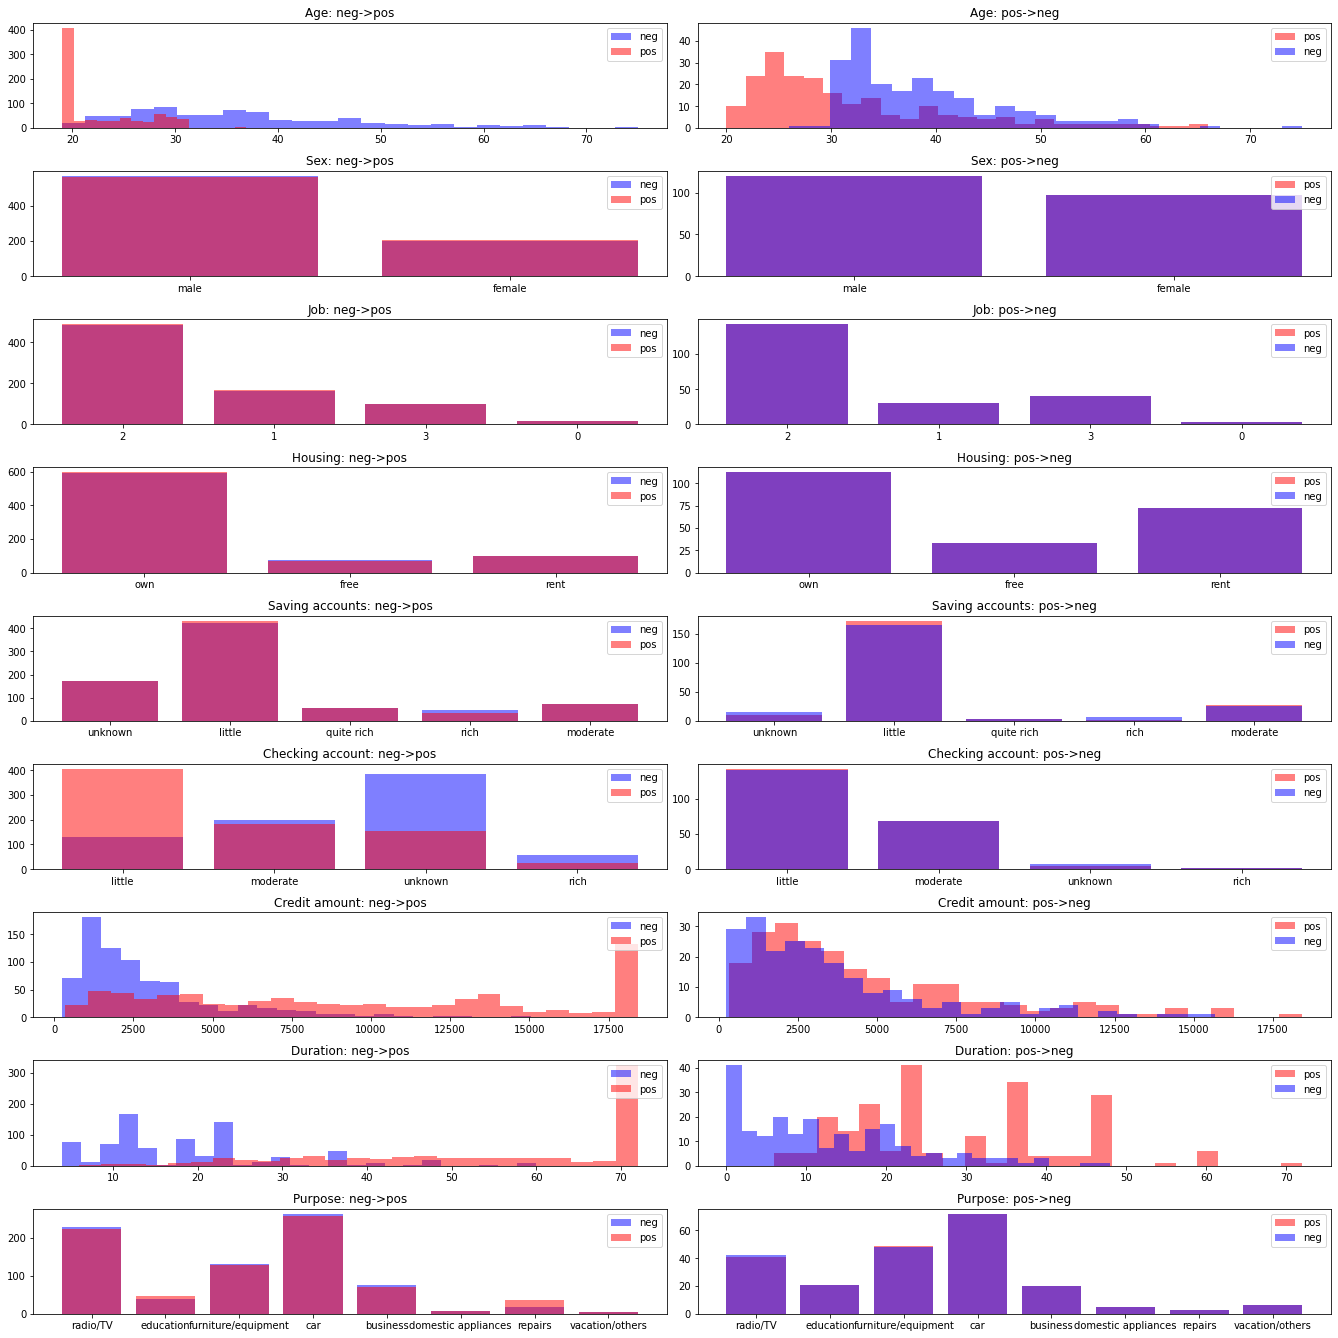

In [6]:
subset = {}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plot_subset_cf(subset_attr_cf)

[690/690]  Epoch-0, time cost: 16.596s, loss: 7.306, iteration: 2000, validation rate: 0.997
Total time cost: 16.751, validation rate: 0.997, average distance: 1.345, average loss: 7.306
[690/690]  Epoch-0, time cost: 16.245s, loss: 7.700, iteration: 2000, validation rate: 0.991
Total time cost: 16.406, validation rate: 0.991, average distance: 1.385, average loss: 7.700


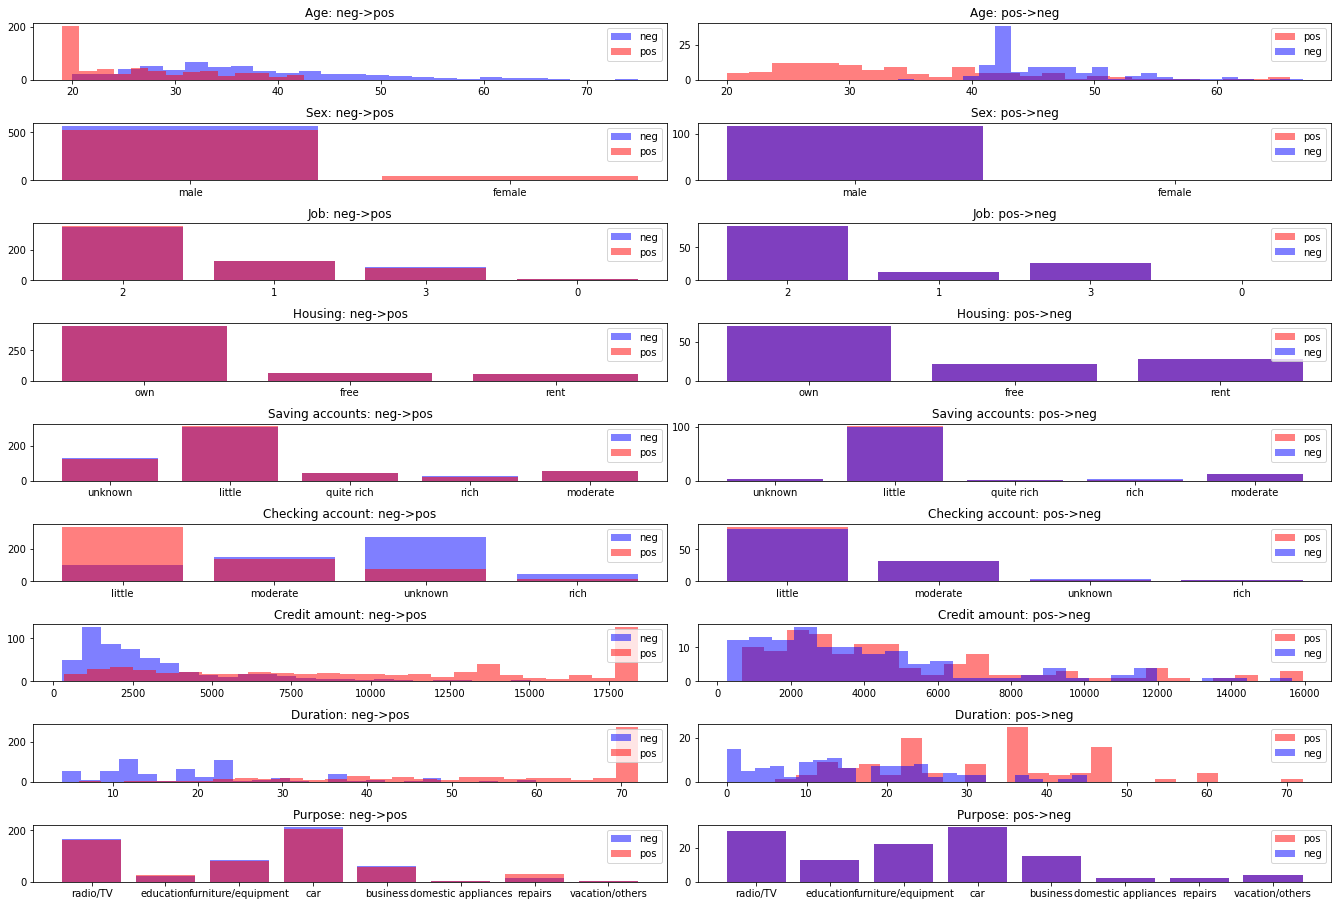

In [7]:
subset = {'Sex': {'category': ['male']}}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 12.5)
plot_subset_cf(subset_attr_cf)

[310/310]  Epoch-0, time cost: 9.761s, loss: 2.375, iteration: 2000, validation rate: 0.952
Total time cost: 9.907, validation rate: 0.952, average distance: 0.967, average loss: 2.375
[310/310]  Epoch-0, time cost: 9.682s, loss: 2.583, iteration: 2000, validation rate: 0.977
Total time cost: 9.841, validation rate: 0.977, average distance: 1.010, average loss: 2.583


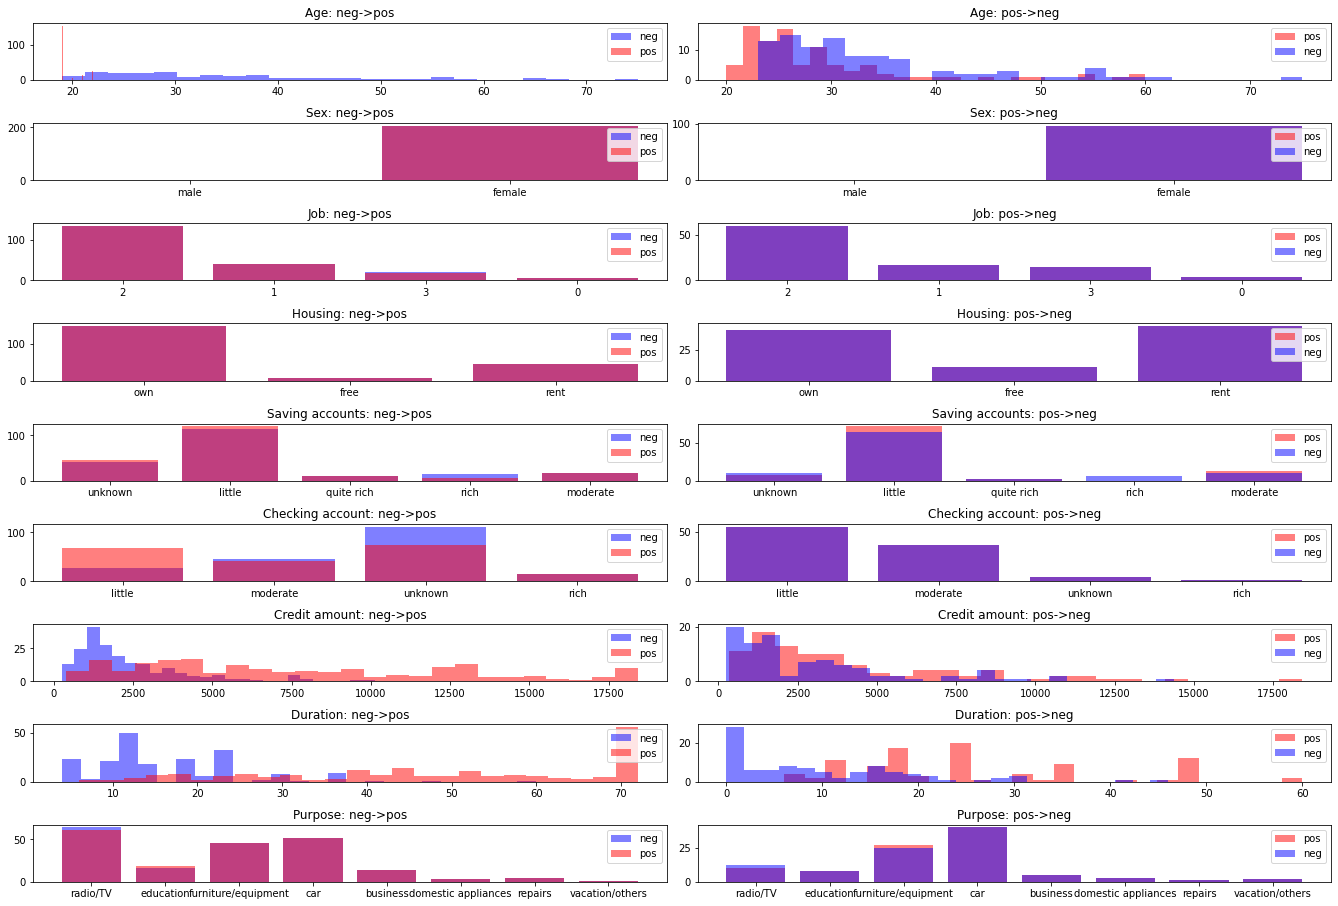

In [8]:
subset = {'Sex': {'category': ['female']}}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 12.5)
plot_subset_cf(subset_attr_cf)

[265/265]  Epoch-0, time cost: 9.752s, loss: 2.087, iteration: 2000, validation rate: 0.966
Total time cost: 9.919, validation rate: 0.966, average distance: 0.970, average loss: 2.087
[265/265]  Epoch-0, time cost: 9.394s, loss: 1.953, iteration: 2000, validation rate: 0.943
Total time cost: 9.547, validation rate: 0.943, average distance: 0.914, average loss: 1.953
[265/265]  Epoch-0, time cost: 9.735s, loss: 2.170, iteration: 2000, validation rate: 0.977
Total time cost: 9.897, validation rate: 0.977, average distance: 0.998, average loss: 2.170


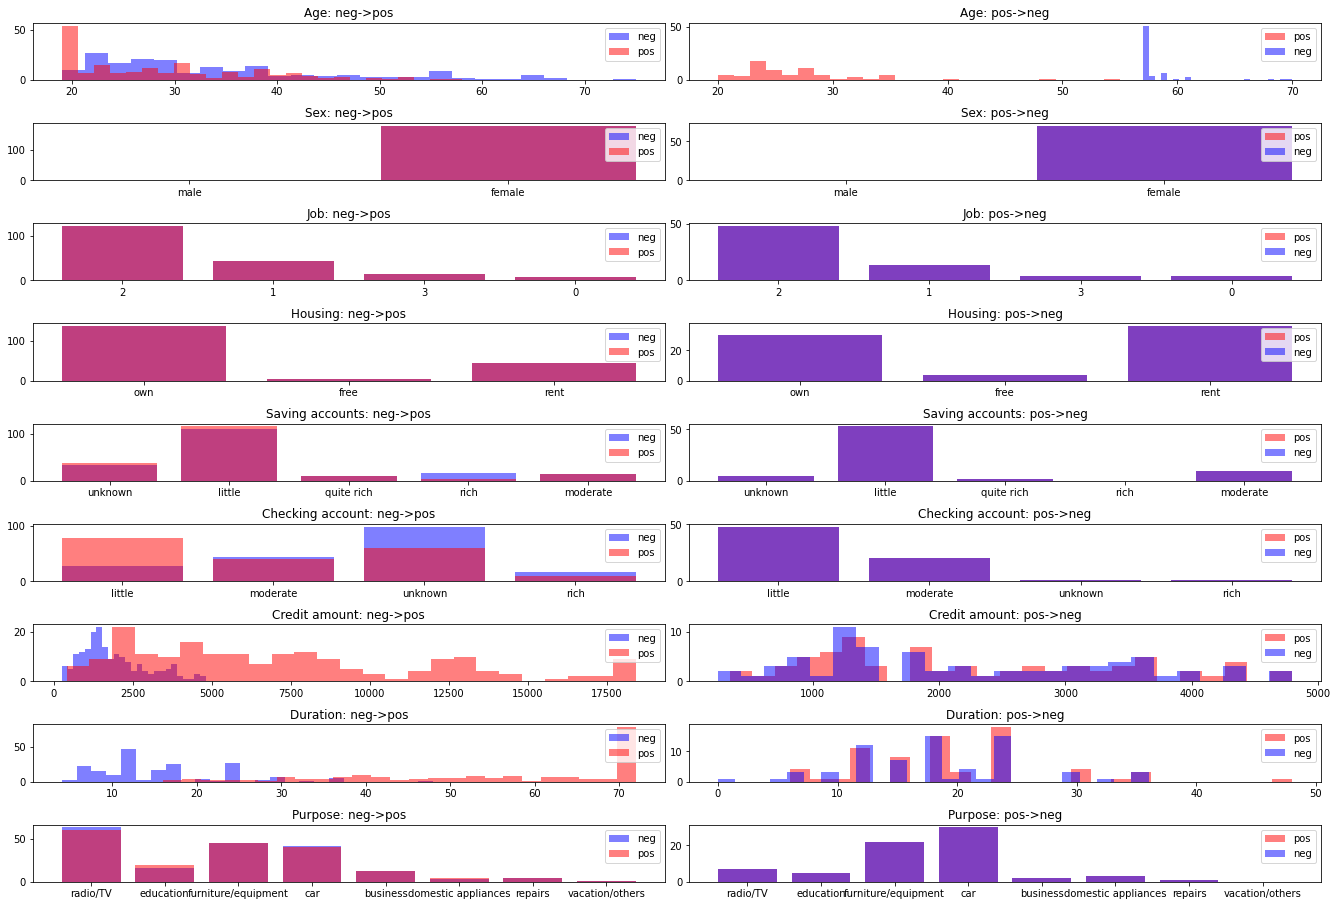

In [9]:
subset = {'Sex': {'category': ['female']}, 'Credit amount': {'min': 0, 'max': 5000}}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 12.5)
plot_subset_cf(subset_attr_cf)